<img src="nhl_banner.png" width="300">

# Introduction

In our ever changing and evolving field of technology one of the foremost topics is data analytics. The growth in the amount of digital data that is being collected across many different fields is massive and research into big data has become of great social and economical interest for not only academic purposes but industry related as well. Data analytics involves taking data in whatever raw form it exists and using technology to transform it into information that has value and context. In some cases data analysis is performed in order to provide class descriptions of the data, highlight behaviors, current trends, changes or associations in the data or even predictive information about the data, all of which useful or even vital to key decision-makers and planners[1]. In essence data analytics is the use of different computational theories, tools and algorithms in order to transform raw data into useful and legible information. For the purpose of this paper, NHL statistics will be processed and analysed using various classification methods to provide a predictive model for estimating future team vs team game winnings.


<img src="map.png" width="800" >

In [1]:
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt

## Data Collection


Using the documentation found on this [GitLab repository](https://gitlab.com/dword4/nhlapi/tree/master), we collected data accessible to the public from the NHL API [2]. The documentation for records and statistics was valuable and gave a place to begin, but after initial exploration it was discovered that several endpoints were unresponsive and much of the documentation was actually quite outdated and thus irrelevant in some cases. As such, the early stages of data collection were primarily repeated trial and error until we were able to collect the necessary data to build our model. Several functions in the following Data Processing section of this notebook were developed to query the API for data on players, teams, and games; some of the collected data came in the form of statistics. Resulting JSON data that was gathered was then converted into a usable format and written to Comma Separated Value (csv) files. The collected data was then converted into model input vectors for each regular season game played between the years 2000 and 2018. The input vectors consisted of team data for both home and away teams for every game in the given season; for the class, a binary label of “0” was applied for an away-team win or a label of “1” for a home-team win. Some of the initially collected data statistics were later dropped from the model input variables after no observable change in prediction accuracy resulted from testing the model with those various parameters or input. 


For each player in the specified year range (years must be consecutive) collect all avalible stats 

|Attribute |Description              |
|-----------|------------------------------------|
|   ID  | ID of the player|
| fullName | Full name |
|   timeOnIce  | Time on ice|
|   assists | Assists during the regular season |
|   goals  | Goals during the regular season |
|   pim  | Penalties in minutes|
|   shots  | Number of shots during the regular season|
|   games  | Number of games played during the regular season|
|   hits  | Number of hits during the regular season|
|   powerPlayGoals  | Power play goals |
|   powerPlayPoints | Power play points |
|   powerPlayTimeOnIce  | Power play time on ice|
|   evenTimeOnIce  | Even strength time on ice  |
|   penaltyMinutes  | Penalty minutes during the regular season |
|   faceOffPct  | Face off win percentage |
|   shotPct  | Shot percentage |
|   gameWinningGoals  | Game winning goals  |
|   overTimeGoals  | Over time goals |
|   shortHandedGoals  | Short handed goals   |
|   shortHandedPoints  | Short handed points |
|   shortHandedTimeOnIce  | Short handed time on ice|
|   blocked  | Number of shots blocked during the regular season |
|   plusMinus  | Plus minus |
|   points  | Points |
|   shifts  | Shifts |
|   timeOnIcePerGame  | Time on ice per game |
|   evenTimeOnIcePerGame  | Even strength time on ice per game |
|   shortHandedTimeOnIcePerGame  | Short handed time on ice per game |
|   powerPlayTimeOnIcePerGame  | Power play time on ice per game |


In [2]:
def get_csv_skaters(y1, y2):
    team_rosters = requests.get('https://statsapi.web.nhl.com/api/v1/teams?expand=team.roster&season=' + y1 + y2)
    team_rosters = team_rosters.json()
    players= []
    for i in range(0, len(team_rosters['teams'])):
        for j in range(0, len(team_rosters['teams'][i]['roster']['roster'])):
            player = [team_rosters['teams'][i]['roster']['roster'][j]['person']['id'], 
                      team_rosters['teams'][i]['roster']['roster'][j]['person']['fullName'],
                     team_rosters['teams'][i]['name']]
            if (team_rosters['teams'][i]['roster']['roster'][j]['position']['code'] != 'G'):
                players.append(player)
    players_stats = []
    labels = requests.get('https://statsapi.web.nhl.com/api/v1/people/' 
                           + str(players[i][0]) 
                           + '/stats?stats=statsSingleSeason&season=' + y1 + y2).json()
    labels = labels['stats'][0]['splits'][0]['stat']
    header = ['id', 'fullName', 'teamName']
    for label in labels:
        header.append(label)
    for i in range(0, len(players)): 
        stats = requests.get('https://statsapi.web.nhl.com/api/v1/people/' 
                           + str(players[i][0]) 
                           + '/stats?stats=statsSingleSeason&season=' + y1 + y2).json()
        if(stats['stats'][0]['splits'] == []):
            players_stats.append([0] * len(labels))
            continue
        stats = stats['stats'][0]['splits'][0]['stat']
        stats_array = []
        for label in labels:
            if label in stats:
                stats_array.append(stats[label])
            else:
                stats_array.append(0)
        players_stats.append(stats_array)
        
    skaters = []
    skaters.append(header)
    for i in range(0, len(players)):
        skaters.append(players[i] + players_stats[i])
    return skaters

Returns the skaters data for a year range and saves the result as a csv file.
Years must be in the range [1917, 2019], note that the 2004-2005 season is skipped as this was a lockout year.

In [3]:
def get_skaters_data(start, end):
    for i in range(start, end):
        if(i == 2004):
            continue
        print("Getting skaters data for " + str(i) + "-" + str(i+1) + " season.")
        skaters = get_csv_skaters(str(i), str(i+1))
        np.savetxt('data/skaters_' + str(i) + '_' + str(i+1) + '.csv', skaters, fmt='%s', delimiter=',')

In [4]:
get_skaters_data(1917,1918)

Getting skaters data for 1917-1918 season.


For each team in the specified year range (years must be consecutive) collect all avalible stats 

|Attribute |Description              |
|-----------|------------------------------------|
|   ID  | ID of the team|
|   teamName  | Team name|
|   gamesPlayed | Games played during the regular season |
|   wins  | The number of wins for the given season |
|   losses  | The number of losses for the given season|
|   ot  | The number of games that went to OT|
|   pts  | The points total for the given season|
|   ptPctg  | The teams points divided by the highest points total|
|   goalsPerGame  | Goals per game|
|   goalsAgainstPerGame | Goals against per game
|   evGGARatio  | Even strength goals against|
|   powerPlayPercentage  | Power play percentage  |
|   powerPlayGoals  | Power play goals |
|   powerPlayGoalsAgainst  | Power play goals against |
|   powerPlayOpportunities  | Power play oppertunitites |
|   penaltyKillPercentage  | Penalty kill percentage  |
|   shotsPerGame  | Shots per game |
|   shotsAllowed  | Shots allowed per game  |
|   winScoreFirst  | Win percentage when scoring first |
|   winOppScoreFirst  | Win percentage when the opponent scores first|
|   winLeadFirstPer  | Win percentage when leading after first period |
|   winLeadSecondPer  | Win percentage when leading after second period |
|   winOutshootOpp  | Win percentage when outshooting opponent |
|   winOutshotByOpp  | Win percentage when outshoot by opponent |
|   faceOffsTaken  | Face offs taken |
|   faceOffsWon  | Face offs won |
|   faceOffsLost  | Face offs lost |
|   faceOffWinPercentage  | Face off win percentage |
|   shootingPctg  | Shooting percentage |
|   savePctg  | Save percentage |
|   PDO | The sum of shooting percentage and save percentage |


In [5]:
def get_csv_team(y1, y2):
    teams = requests.get('https://statsapi.web.nhl.com/api/v1/teams?season=' + str(y1) + str(y2))
    teams = teams.json()
    team_id_name = []
    for i in range(0, len(teams['teams'])):
        team_arr = [teams['teams'][i]['id'], teams['teams'][i]['name']]
        team_id_name.append(team_arr)

    labels = requests.get('https://statsapi.web.nhl.com/api/v1/teams/' 
                           + str(team_id_name[0][0])
                           + '/stats?stats=statsSingleSeason&season=' + str(y1) + str(y2)).json()
    labels = labels['stats'][0]['splits'][0]['stat']
    
    header = ['id', 'teamName']
    for label in labels:
        header.append(label)
    header.append('PDO')
    team_stats = []
    for i in range(0, len(team_id_name)):
        stats = requests.get('https://statsapi.web.nhl.com/api/v1/teams/' 
                             + str(team_id_name[i][0]) 
                             + '/stats?stats=statsSingleSeason&season=' + str(y1) + str(y2)).json()
        if(stats['stats'][0]['splits'] == []):
            team_stats.append([0] * len(labels))
            continue
        stats = stats['stats'][0]['splits'][0]['stat']
        stats_array = []
        for label in labels:
            if label in stats:
                stats_array.append(stats[label])
            else:
                stats_array.append(0)
        team_stats.append(stats_array)
        stats_array.append((stats['shootingPctg']/100) + stats['savePctg'])
    
    teams_stats_final = []
    teams_stats_final.append(header)
    for i in range(0, len(team_id_name)):
        teams_stats_final.append(team_id_name[i] + team_stats[i]) 
    return teams_stats_final

Gets the team data for a year range and saves the result as a csv file.
Years must be in the range [1917, 2019], note that the 2004-2005 season is skipped as this was a lockout year.

In [6]:
def get_team_data(start, end):
    for i in range(start, end):
        if(i == 2004):
            continue
        print("Getting team data for " + str(i) + "-" + str(i+1) + " season.")
        data = get_csv_team(str(i), str(i+1))
        np.savetxt('team_data/teams_' + str(i) + '_' + str(i+1) + '.csv', data, fmt='%s', delimiter=',')

In [7]:
get_team_data(2017, 2018)

Getting team data for 2017-2018 season.


Returns the index of the team stats 

In [8]:
def get_team_stats(id, team_data):
    for i in range(0, len(team_data)):
        if team_data[i][0] == id:
            return i

For each game in the specified year range (years must be consecutive) return the winner, away team ID, home team ID, and the away and home team stats for that season. The following table gives a description of each stat

|Attribute |Description              |
|-----------|------------------------------------|
|   winner  | 0 for an away win, 1 for a home win|
|   awayID  | ID of the away team|
|   homeID  | ID of the home team|
|   wins  | The number of wins for the given season |
|   losses  | The number of losses for the given season|
|   ot  | The number of games that went to OT|
|   pts  | The points total for the given season|
|   ptPctg  | The teams points divided by the highest points total|
|   goalsPerGame  | Goals per game|
|   goalsAgainstPerGame | Goals against per game
|   evGGARatio  | Even strength goals against|
|   powerPlayPercentage  | Power play percentage  |
|   powerPlayGoals  | Power play goals |
|   powerPlayGoalsAgainst  | Power play goals against |
|   powerPlayOpportunities  | Power play oppertunitites |
|   penaltyKillPercentage  | Penalty kill percentage  |
|   shotsPerGame  | Shots per game |
|   shotsAllowed  | Shots allowed per game  |
|   winScoreFirst  | Win percentage when scoring first |
|   winOppScoreFirst  | Win percentage when the opponent scores first|
|   winLeadFirstPer  | Win percentage when leading after first period |
|   winLeadSecondPer  | Win percentage when leading after second period |
|   winOutshootOpp  | Win percentage when outshooting opponent |
|   winOutshotByOpp  | Win percentage when outshoot by opponent |
|   faceOffsTaken  | Face offs taken |
|   faceOffsWon  | Face offs won |
|   faceOffsLost  | Face offs lost |
|   faceOffWinPercentage  | Face off win percentage |
|   shootingPctg  | Shooting percentage |
|   savePctg  | Save percentage |
|   PDO | The sum of shooting percentage and save percentage |


In [9]:
def get_csv_game(y1, y2):
    team_data = get_csv_team(y1, y2)
    header = team_data[0][3:]
    away_header = []
    home_header = []
    for head in header:
        away_header.append('away_'+head)
        home_header.append('home_'+head)
    games_data = [['winner', 'awayID', 'homeID'] + away_header + home_header]
    games = requests.get('https://statsapi.web.nhl.com/api/v1/schedule?startDate=' 
                         + str(y1) + '-10-01&endDate=' + str(y2) + '-06-30')
    games = games.json()
    for date in games['dates']:
        for game in date['games']:
            away_ID = game['teams']['away']['team']['id']
            home_ID = game['teams']['home']['team']['id']
            if away_ID > 80 or home_ID > 80:
                continue
            
            away_score = game['teams']['away']['score']
            home_score = game['teams']['home']['score']
            winner = 0
            away_stats = team_data[get_team_stats(away_ID, team_data)][3:]
            home_stats = team_data[get_team_stats(home_ID, team_data)][3:]
            if home_score > away_score:
                winner = 1
            games_data.append([winner,
                          away_ID, 
                          home_ID] +
                          away_stats +
                          home_stats)
    return games_data

Gets the game data for a year range and saves the result as a csv file.
Years must be in the range [1917, 2019], note that the 2004-2005 season is skipped as this was a lockout year.

In [10]:
def get_game_data(start, end):
    for i in range(start, end):
        if(i == 2004):
            continue
        print("Getting game data for " + str(i) + "-" + str(i+1) + " season.")
        data = get_csv_game(i, i+1)
        np.savetxt('game_data/game_data_' + str(i) + '_' + str(i+1) + '.csv', data, fmt='%s', delimiter=',')

In [11]:
get_game_data(2017,2018)

Getting game data for 2017-2018 season.


Setup a master csv file containg all the game data for later use

In [12]:
data_2000_2001 = pd.read_csv('game_data/game_data_2000_2001.csv', header=0)
data_2001_2002 = pd.read_csv('game_data/game_data_2001_2002.csv', header=0)
data_2002_2003 = pd.read_csv('game_data/game_data_2002_2003.csv', header=0)
data_2003_2004 = pd.read_csv('game_data/game_data_2003_2004.csv', header=0)
data_2005_2006 = pd.read_csv('game_data/game_data_2005_2006.csv', header=0)
data_2006_2007 = pd.read_csv('game_data/game_data_2006_2007.csv', header=0)
data_2007_2008 = pd.read_csv('game_data/game_data_2007_2008.csv', header=0)
data_2008_2009 = pd.read_csv('game_data/game_data_2008_2009.csv', header=0)
data_2009_2010 = pd.read_csv('game_data/game_data_2009_2010.csv', header=0)
data_2010_2011 = pd.read_csv('game_data/game_data_2010_2011.csv', header=0)
data_2011_2012 = pd.read_csv('game_data/game_data_2011_2012.csv', header=0)
data_2012_2013 = pd.read_csv('game_data/game_data_2012_2013.csv', header=0)
data_2013_2014 = pd.read_csv('game_data/game_data_2013_2014.csv', header=0)
data_2014_2015 = pd.read_csv('game_data/game_data_2014_2015.csv', header=0)
data_2015_2016 = pd.read_csv('game_data/game_data_2015_2016.csv', header=0)
data_2016_2017 = pd.read_csv('game_data/game_data_2016_2017.csv', header=0)
data_2017_2018 = pd.read_csv('game_data/game_data_2017_2018.csv', header=0)

frames = [data_2000_2001, data_2001_2002, data_2002_2003, data_2003_2004, data_2005_2006, 
          data_2006_2007, data_2007_2008, data_2008_2009, data_2009_2010, data_2010_2011, 
          data_2011_2012, data_2012_2013, data_2013_2014, data_2014_2015, data_2015_2016, 
          data_2016_2017, data_2017_2018]

data = pd.concat(frames)

data = data.drop(['away_wins', 'away_losses', 'away_ot',
       'away_pts', 'away_ptPctg', 'away_powerPlayGoals',
       'away_powerPlayGoalsAgainst', 'away_powerPlayOpportunities','away_shotsPerGame', 'away_shotsAllowed',
       'away_winScoreFirst', 'away_winOppScoreFirst', 'away_winLeadFirstPer',
       'away_winLeadSecondPer', 'away_winOutshootOpp', 'away_winOutshotByOpp',
       'away_faceOffsTaken', 'away_faceOffsWon', 'away_faceOffsLost',
       'away_faceOffWinPercentage',
       'home_wins', 'home_losses', 'home_ot',
       'home_pts', 'home_ptPctg', 'home_powerPlayGoals',
       'home_powerPlayGoalsAgainst', 'home_powerPlayOpportunities','home_shotsPerGame', 'home_shotsAllowed',
       'home_winScoreFirst', 'home_winOppScoreFirst', 'home_winLeadFirstPer',
       'home_winLeadSecondPer', 'home_winOutshootOpp', 'home_winOutshotByOpp',
       'home_faceOffsTaken', 'home_faceOffsWon', 'home_faceOffsLost',
       'home_faceOffWinPercentage'], axis=1)
header = ['winner', 'awayID', 'homeID', 'away_goalsPerGame',
       'away_goalsAgainstPerGame', 'away_evGGARatio',
       'away_powerPlayPercentage', 'away_penaltyKillPercentage',
       'away_shootingPctg', 'away_savePctg', 'away_PDO', 'home_goalsPerGame',
       'home_goalsAgainstPerGame', 'home_evGGARatio',
       'home_powerPlayPercentage', 'home_penaltyKillPercentage',
       'home_shootingPctg', 'home_savePctg', 'home_PDO']
header = ','.join(header)

np.savetxt('master.csv', data, fmt='%s', delimiter=',', header = header)

Data Preprocessing
--

Raw data is rarely ever perfect in form or viability for successful data mining. It must be prepared in order to provide mining tools with useful, clean content so that its information and behavior can be brought to light. The effectiveness of a data mining process for a particular dataset is inherently linked to the quality of the data as well as the understanding of the data by the data miner performing the analysis. Data preprocessing and visualization enables this. Throughout the initial stages of this project, data processing became an iterative step that was repeated many times after visualizing and performing initial analysis of the preprocessed data. One such step was normalization which transformed varying variable range values into easily interpretable ranges of values centred on zero that allowed for reduction in data redundancy as well as a more clear analysis across variables. Feature or attribute selection for model input also proved be an iterative step. The number of chosen features from the many available through the API was reduced based on hockey statistics research and attribute evaluation analysis. Based on related work by Weissbock, we added a PDO variable(the sum of shooting percentage and save percentage), as it was shown to be a good proxy for the overall “luck” of a team [3]. 

In [13]:
def normalize(data):
    max_data = np.max(data, axis=0)
    min_data = np.min(data, axis=0)
    stats = ['away_wins', 'away_losses', 'away_ot',
             'away_pts', 'away_ptPctg', 'away_goalsPerGame',
             'away_goalsAgainstPerGame', 'away_evGGARatio',
             'away_powerPlayPercentage', 'away_powerPlayGoals',
             'away_powerPlayGoalsAgainst', 'away_powerPlayOpportunities',
             'away_penaltyKillPercentage', 'away_shotsPerGame', 'away_shotsAllowed',
             'away_winScoreFirst', 'away_winOppScoreFirst', 'away_winLeadFirstPer',
             'away_winLeadSecondPer', 'away_winOutshootOpp', 'away_winOutshotByOpp',
             'away_faceOffsTaken', 'away_faceOffsWon', 'away_faceOffsLost',
             'away_faceOffWinPercentage', 'away_shootingPctg', 'away_savePctg', 'away_PDO',
             'home_wins', 'home_losses', 'home_ot', 'home_pts', 'home_ptPctg',
             'home_goalsPerGame', 'home_goalsAgainstPerGame', 'home_evGGARatio',
             'home_powerPlayPercentage', 'home_powerPlayGoals',
             'home_powerPlayGoalsAgainst', 'home_powerPlayOpportunities',
             'home_penaltyKillPercentage', 'home_shotsPerGame', 'home_shotsAllowed',
             'home_winScoreFirst', 'home_winOppScoreFirst', 'home_winLeadFirstPer',
             'home_winLeadSecondPer', 'home_winOutshootOpp', 'home_winOutshotByOpp',
             'home_faceOffsTaken', 'home_faceOffsWon', 'home_faceOffsLost',
             'home_faceOffWinPercentage', 'home_shootingPctg', 'home_savePctg', 'home_PDO']
    for stat in stats:
        data[stat] = (data[stat] - min_data[stat])/(max_data[stat] - min_data[stat])
    return data

In [14]:
data_2000_2001 = pd.read_csv('game_data/game_data_2000_2001.csv', header=0)
data_2001_2002 = pd.read_csv('game_data/game_data_2001_2002.csv', header=0)
data_2002_2003 = pd.read_csv('game_data/game_data_2002_2003.csv', header=0)
data_2003_2004 = pd.read_csv('game_data/game_data_2003_2004.csv', header=0)
data_2005_2006 = pd.read_csv('game_data/game_data_2005_2006.csv', header=0)
data_2006_2007 = pd.read_csv('game_data/game_data_2006_2007.csv', header=0)
data_2007_2008 = pd.read_csv('game_data/game_data_2007_2008.csv', header=0)
data_2008_2009 = pd.read_csv('game_data/game_data_2008_2009.csv', header=0)
data_2009_2010 = pd.read_csv('game_data/game_data_2009_2010.csv', header=0)
data_2010_2011 = pd.read_csv('game_data/game_data_2010_2011.csv', header=0)
data_2011_2012 = pd.read_csv('game_data/game_data_2011_2012.csv', header=0)
data_2012_2013 = pd.read_csv('game_data/game_data_2012_2013.csv', header=0)
data_2013_2014 = pd.read_csv('game_data/game_data_2013_2014.csv', header=0)
data_2014_2015 = pd.read_csv('game_data/game_data_2014_2015.csv', header=0)
data_2015_2016 = pd.read_csv('game_data/game_data_2015_2016.csv', header=0)
data_2016_2017 = pd.read_csv('game_data/game_data_2016_2017.csv', header=0)
data_2017_2018 = pd.read_csv('game_data/game_data_2017_2018.csv', header=0)

data_2000_2001 = normalize(data_2000_2001)
data_2001_2002 = normalize(data_2001_2002)
data_2002_2003 = normalize(data_2002_2003)
data_2003_2004 = normalize(data_2003_2004)
data_2005_2006 = normalize(data_2005_2006)
data_2006_2007 = normalize(data_2006_2007)
data_2007_2008 = normalize(data_2007_2008)
data_2008_2009 = normalize(data_2008_2009)
data_2009_2010 = normalize(data_2009_2010)
data_2010_2011 = normalize(data_2010_2011)
data_2011_2012 = normalize(data_2011_2012)
data_2012_2013 = normalize(data_2012_2013)
data_2013_2014 = normalize(data_2013_2014)
data_2014_2015 = normalize(data_2014_2015)
data_2016_2017 = normalize(data_2016_2017)
data_2017_2018 = normalize(data_2017_2018)

frames = [data_2000_2001, data_2001_2002, data_2002_2003, data_2003_2004, data_2005_2006, 
          data_2006_2007, data_2007_2008, data_2008_2009, data_2009_2010, data_2010_2011, 
          data_2011_2012, data_2012_2013, data_2013_2014, data_2014_2015, data_2015_2016, 
          data_2016_2017, data_2017_2018]

data = pd.concat(frames)

data = data.drop(['away_wins', 'away_losses', 'away_ot',
       'away_pts', 'away_ptPctg', 'away_powerPlayGoals',
       'away_powerPlayGoalsAgainst', 'away_powerPlayOpportunities','away_shotsPerGame', 'away_shotsAllowed',
       'away_winScoreFirst', 'away_winOppScoreFirst', 'away_winLeadFirstPer',
       'away_winLeadSecondPer', 'away_winOutshootOpp', 'away_winOutshotByOpp',
       'away_faceOffsTaken', 'away_faceOffsWon', 'away_faceOffsLost',
       'away_faceOffWinPercentage',
       'home_wins', 'home_losses', 'home_ot',
       'home_pts', 'home_ptPctg', 'home_powerPlayGoals',
       'home_powerPlayGoalsAgainst', 'home_powerPlayOpportunities','home_shotsPerGame', 'home_shotsAllowed',
       'home_winScoreFirst', 'home_winOppScoreFirst', 'home_winLeadFirstPer',
       'home_winLeadSecondPer', 'home_winOutshootOpp', 'home_winOutshotByOpp',
       'home_faceOffsTaken', 'home_faceOffsWon', 'home_faceOffsLost',
       'home_faceOffWinPercentage'], axis=1)
header = ['winner', 'awayID', 'homeID', 'away_goalsPerGame',
       'away_goalsAgainstPerGame', 'away_evGGARatio',
       'away_powerPlayPercentage', 'away_penaltyKillPercentage',
       'away_shootingPctg', 'away_savePctg', 'away_PDO', 'home_goalsPerGame',
       'home_goalsAgainstPerGame', 'home_evGGARatio',
       'home_powerPlayPercentage', 'home_penaltyKillPercentage',
       'home_shootingPctg', 'home_savePctg', 'home_PDO']
header = ','.join(header)

np.savetxt('master_normalized.csv', data, fmt='%s', delimiter=',', header = header)

# Data Visualization

An important tool in data analytics is data visualization. Data visualization aids in understanding the structure of the data as well as the relationships between features in the data. The number of attributes associated with our model as well as the size of the dataset made data visualization difficult. So, for visualization purposes, a subset of the data was created by grouping games by home-team then averaging the wins against each away-team. A comparison of the number of instances in the master dataset and the subset is shown in the following 3D visualizations of the top three features based on WEKA Info Gain Attribute Evaluation.[attributeSelection.InfoGainAttributeEval.png] This evaluation determines the worth of an attributes by measuring the information gain with respect to the winner class. In order of highest ranking, on the x-axis is home_evGGARatio, on the y-axis is away_evGGARatio and on the z-axis is home_goalsPerGame. 
#### Highest Ranking Attributes Master
<img src="weka_imgs/3D-master-home_evGGARatio-away_evGGARatio-home_goalsPerGame.png" width="500">
#### Highest Ranking Attributes Subset
<img src="weka_imgs/3D-home_evGGARatio-away_evGGARatio-home_goalsPerGame.png" width="500"> 
Obviously, the relationship between attributes is more clearly seen with fewer instance points in the latter plot. Each attribute plot below shows the distribution of the feature values in the subset as well as the difference in instances classes as a win or a loss.
#### Away attributes 
<img src="weka_imgs/awayAttributes.png" width="500">
#### Home attributes 
<img src="weka_imgs/homeAttributes.png" width="500"> 
The added win average for each home-team game against each away-team provides a means to visualize attribute separability on a scale rather than just as “0” or “1” (loss or win) as shown in the 3D plot with winAVG-home on the x-axis and home_evGGARatio and away_evGGARatio on the y and z-axes, respectively. [3D-winAVG-home_evGGARatio-away_evGGARatio.png] The following matrix is an example of Pearson’s correlation illustrating how closely related the features in our data subset are, note the low correlation with any other features and the winner class. 

In [15]:
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns
%matplotlib inline

In [16]:
data = pd.read_csv('master_normalized_avgWin.csv', header=0)

data.head()

,win,winAvg,awayID,homeID,latitude,longitude,away_goalsPerGame,away_goalsAgainstPerGame,away_evGGARatio,away_powerPlayPercentage,...,away_savePctg,away_PDO,home_goalsPerGame,home_goalsAgainstPerGame,home_evGGARatio,home_powerPlayPercentage,home_penaltyKillPercentage,home_shootingPctg,home_savePctg,home_PDO
0,1,0.540000,2,1,39.833851,-74.871826,0.684492,1.000000,0.383403,0.743363,...,0.233333,0.571429,0.488414,0.418018,0.423169,0.584071,0.728814,0.516129,0.5,0.571429
1,1,0.568966,3,1,39.833851,-74.871826,0.325312,0.670270,0.222239,0.566372,...,0.533333,0.530612,0.488414,0.418018,0.423169,0.584071,0.728814,0.516129,0.5,0.571429
2,1,0.637931,4,1,39.833851,-74.871826,0.554367,0.373874,0.620648,0.522124,...,0.366667,0.530612,0.488414,0.418018,0.423169,0.584071,0.728814,0.516129,0.5,0.571429
3,1,0.588235,5,1,39.833851,-74.871826,0.782531,0.505405,0.358193,1.000000,...,0.333333,0.530612,0.488414,0.418018,0.423169,0.584071,0.728814,0.516129,0.5,0.571429
4,1,0.500000,6,1,39.833851,-74.871826,0.749554,0.099099,0.790516,0.778761,...,0.633333,0.775510,0.488414,0.418018,0.423169,0.584071,0.728814,0.516129,0.5,0.571429


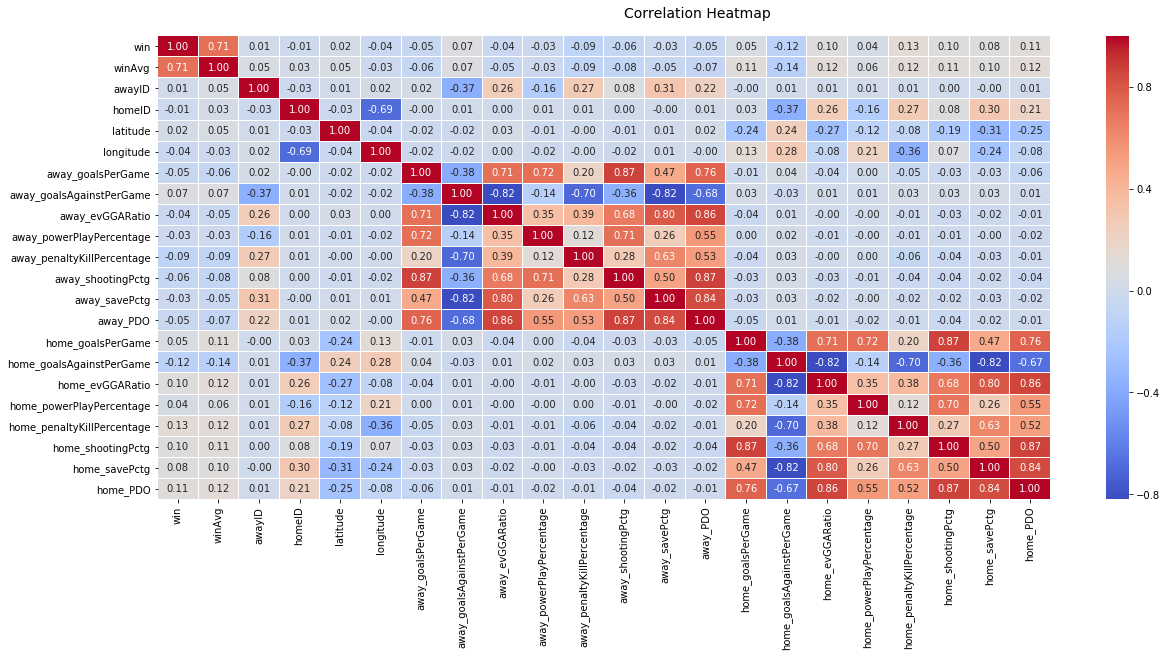

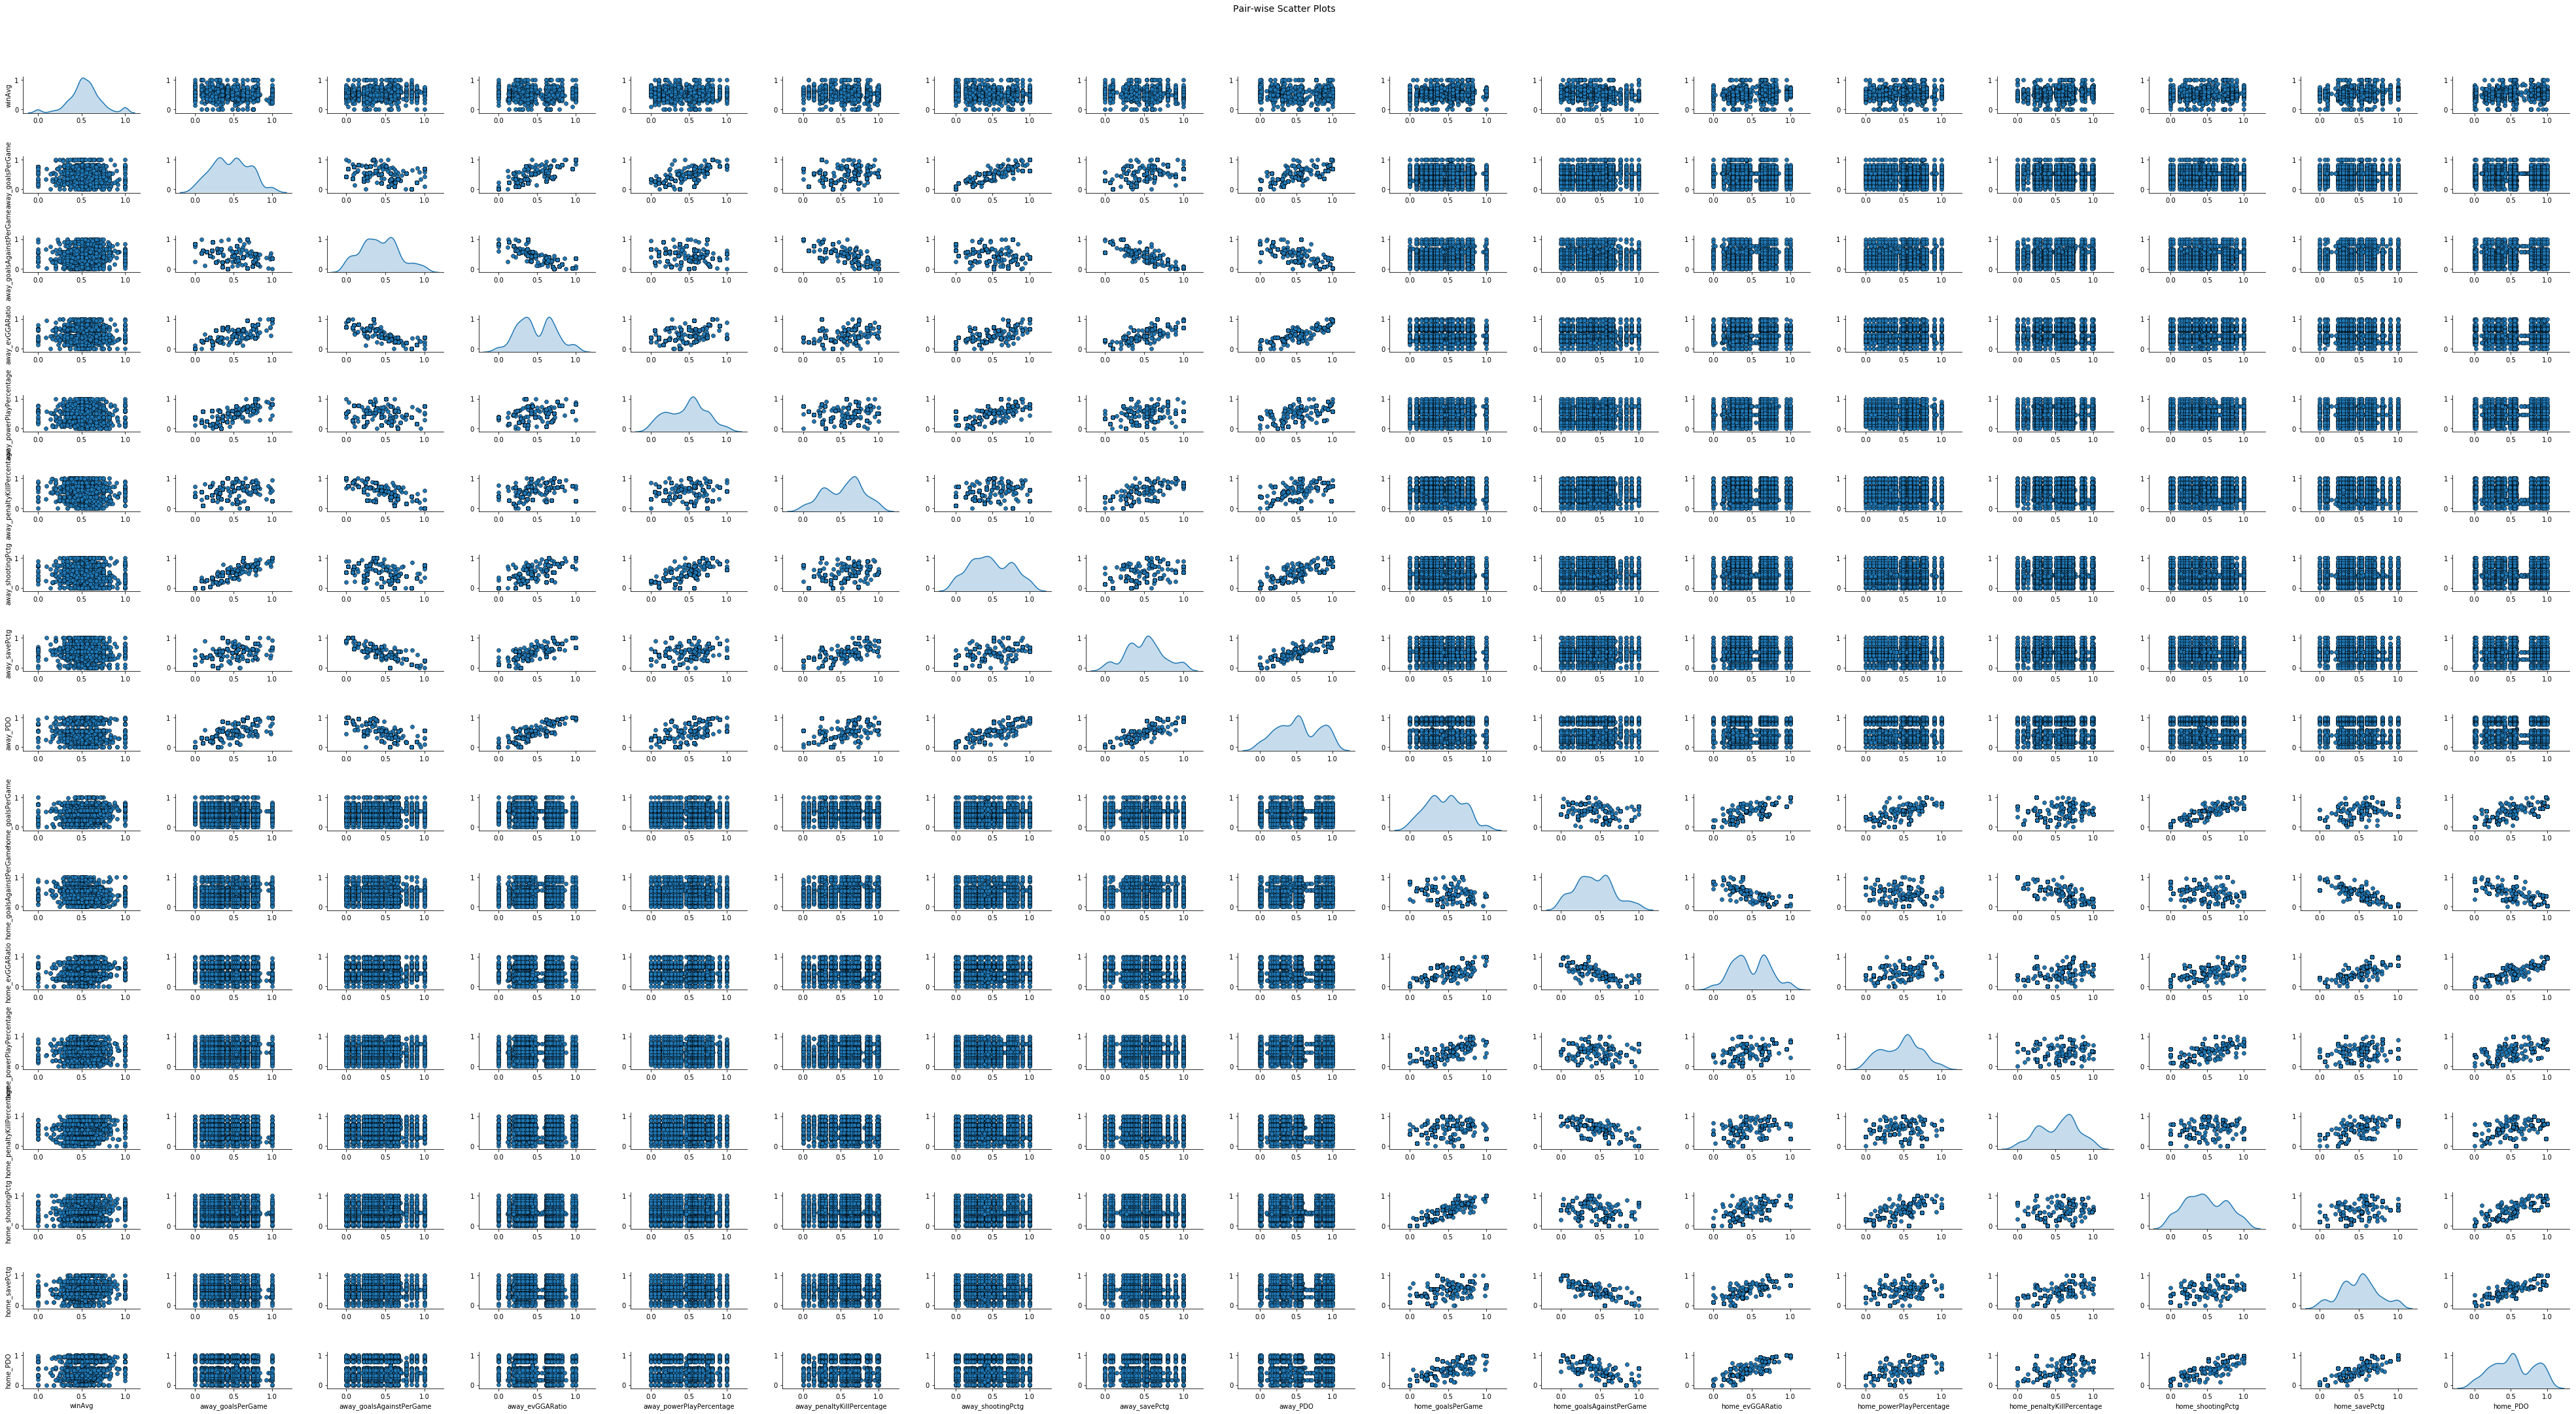

In [17]:
# # Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(20, 8))
corr = data.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Correlation Heatmap', fontsize=14)

# Pair-wise Scatter Plots
cols = ['winAvg', 'away_goalsPerGame',
       'away_goalsAgainstPerGame', 'away_evGGARatio',
       'away_powerPlayPercentage', 'away_penaltyKillPercentage',
       'away_shootingPctg', 'away_savePctg', 'away_PDO', 'home_goalsPerGame',
       'home_goalsAgainstPerGame', 'home_evGGARatio',
       'home_powerPlayPercentage', 'home_penaltyKillPercentage',
       'home_shootingPctg', 'home_savePctg', 'home_PDO']
pp = sns.pairplot(data[cols], size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Pair-wise Scatter Plots', fontsize=14)

Anaylsis
--

Of the many available data mining methods, primary focus was applied to regression analysis to determine if the outcome of a winning game, the dependent variable, could be explained by a group of independent variables.


## WEKA

Attribute selection: Info Gain Attribute Eval(Evaluates the worth of an attribute by measuring the information gain with respect to the class), Classifier Attribute Eval(Evaluates the worth of an attribute by using a user-specified classifier - ID3),  Pearson’s Correlation Attribute Eval(Evaluates the worth of an attribute by measuring the correlation between it and the class)
Classification: ID3, J48, Random Forest, Naíve Bayes


## Regression

We trained 4 support vector machines (SVMs), each with a different kernel function. The goal of using 4 different kernel functions was to see if the addition of new features could improve the classification accuracy. Each SVMs accuracy was evaluated separately with scores ranging from 54-60%. We also used an ensemble model to take the average prediction from all 4 SVMs. The ensemble accuracy was 58-60%.

In [18]:
import pandas as pd
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import classification_report, confusion_matrix  

In [19]:
def prepare(data):
    X = data.iloc[:,3:].values
    # we insert an all-ones column at index 0
    X = np.insert(X, 0, 1, axis=1)
    # get the first column of the data
    y = data.iloc[:,0:1].values
    return X,y

def split_train_test(X,y,pct=80):
    n = X.shape[0]
    s = round(n * pct / 100)
    
    indices = np.random.permutation(n)
    train_idx, test_idx = indices[:s], indices[s:]
    
    X_train, X_test = X[train_idx,:], X[test_idx,:]
    y_train, y_test = y[train_idx,:], y[test_idx,:]
    
    return X_train, y_train, X_test, y_test

def accuracy(pred, labels):
    count = 0
    for i in range(0, len(pred)):
        if(pred[i] == labels[i]):
            count += 1
    return count/len(pred)

## SVM using several kernal functions


In [20]:
data = pd.read_csv('master_normalized.csv', header=0)

In [21]:
X,y = prepare(data)

X,Y,X_test,Y_test = split_train_test(X,y,pct=80)

Y = np.concatenate(Y, axis=0 )

In [22]:
data.head()

,# winner,awayID,homeID,away_goalsPerGame,away_goalsAgainstPerGame,away_evGGARatio,away_powerPlayPercentage,away_penaltyKillPercentage,away_shootingPctg,away_savePctg,away_PDO,home_goalsPerGame,home_goalsAgainstPerGame,home_evGGARatio,home_powerPlayPercentage,home_penaltyKillPercentage,home_shootingPctg,home_savePctg,home_PDO
0,0.0,21.0,25.0,0.803099,0.075019,0.789802,0.932331,0.475248,0.885714,0.700000,0.944444,0.574564,0.027842,0.620057,0.751880,0.821782,0.942857,0.733333,1.000000
1,0.0,9.0,6.0,0.834087,0.197989,0.734781,0.676692,0.841584,0.828571,0.733333,0.925926,0.464170,0.613302,0.795786,0.511278,0.475248,0.400000,0.000000,0.240741
2,1.0,16.0,7.0,0.330536,0.584687,0.664542,0.248120,0.594059,0.428571,0.066667,0.296296,0.393802,0.000000,0.502732,0.488722,1.000000,0.485714,1.000000,0.851852
3,1.0,23.0,4.0,0.559070,0.508894,0.767300,0.563910,0.287129,0.457143,0.066667,0.314815,0.566817,0.216551,1.000000,0.458647,0.445545,0.457143,0.566667,0.592593
4,0.0,17.0,20.0,0.668819,0.169374,0.849896,0.939850,0.772277,0.371429,0.766667,0.648148,0.227889,0.490333,0.444459,0.398496,0.188119,0.171429,0.266667,0.240741


## Linear SVC

In [23]:
linear_svc = svm.SVC(kernel='linear')

In [24]:
linear_svc.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
linear_Y_pred = linear_svc.predict(X_test)

In [26]:
lin_acc = accuracy(linear_Y_pred, Y_test)

In [27]:
print(lin_acc)

0.5974231464737794


In [28]:
print(confusion_matrix(Y_test, linear_Y_pred))  
print(classification_report(Y_test, linear_Y_pred)) 

[[ 909 1144]
 [ 637 1734]]
             precision    recall  f1-score   support

        0.0       0.59      0.44      0.51      2053
        1.0       0.60      0.73      0.66      2371

avg / total       0.60      0.60      0.59      4424



## Polynomial SVC - degree 3

In [29]:
poly_svc = svm.SVC(kernel='poly', degree=3)

In [30]:
poly_svc.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [31]:
poly_Y_pred = poly_svc.predict(X_test)  

In [32]:
poly_acc = accuracy(poly_Y_pred, Y_test)

In [33]:
print(poly_acc)

0.588381555153707


In [34]:
print(confusion_matrix(Y_test, poly_Y_pred))  
print(classification_report(Y_test, poly_Y_pred)) 

[[ 697 1356]
 [ 465 1906]]
             precision    recall  f1-score   support

        0.0       0.60      0.34      0.43      2053
        1.0       0.58      0.80      0.68      2371

avg / total       0.59      0.59      0.56      4424



## Gaussian SVC 

In [35]:
gaussian_svc = svm.SVC(kernel='rbf')

In [36]:
gaussian_svc.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [37]:
gaussian_Y_pred = gaussian_svc.predict(X_test)  

In [38]:
gaussian_acc = accuracy(gaussian_Y_pred, Y_test)

In [39]:
print(gaussian_acc)

0.5962929475587704


In [40]:
print(confusion_matrix(Y_test, poly_Y_pred))  
print(classification_report(Y_test, poly_Y_pred)) 

[[ 697 1356]
 [ 465 1906]]
             precision    recall  f1-score   support

        0.0       0.60      0.34      0.43      2053
        1.0       0.58      0.80      0.68      2371

avg / total       0.59      0.59      0.56      4424



## Sigmoid SVC

In [41]:
sigmoid_svc = svm.SVC(kernel='sigmoid')

In [42]:
sigmoid_svc.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [43]:
sigmoid_Y_pred = sigmoid_svc.predict(X_test)  

In [44]:
sigmoid_acc = accuracy(sigmoid_Y_pred, Y_test)

In [45]:
print(sigmoid_acc)

0.5452079566003617


In [46]:
print(confusion_matrix(Y_test, sigmoid_Y_pred))  
print(classification_report(Y_test, sigmoid_Y_pred)) 

[[ 990 1063]
 [ 949 1422]]
             precision    recall  f1-score   support

        0.0       0.51      0.48      0.50      2053
        1.0       0.57      0.60      0.59      2371

avg / total       0.54      0.55      0.54      4424



## XGBoost

In [50]:
import pandas as pd
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import classification_report, confusion_matrix   
import xgboost as xgb

In [51]:
xg = xgb.XGBClassifier(seed = 21)

xg.fit(X, Y.ravel())

xg_Y_pred = xg.predict(X_test)  

xg_acc = accuracy(xg_Y_pred, Y_test)

print(xg_acc)

print(confusion_matrix(Y_test, xg_Y_pred))  
print(classification_report(Y_test, xg_Y_pred)) 

0.5901898734177216
[[ 910 1143]
 [ 670 1701]]
             precision    recall  f1-score   support

        0.0       0.58      0.44      0.50      2053
        1.0       0.60      0.72      0.65      2371

avg / total       0.59      0.59      0.58      4424



In [52]:
from sklearn.model_selection import GridSearchCV

In [53]:
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

In [54]:
clf = xgb.XGBClassifier(seed=2)

In [55]:
grid_obj = GridSearchCV(clf,
                        param_grid=parameters,
                        cv=5)

In [56]:
grid_obj = grid_obj.fit(X, Y.ravel())

In [57]:
clf = grid_obj.best_estimator_
print (clf)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=3, missing=None,
       n_estimators=40, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=1e-05,
       reg_lambda=1, scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8)


In [58]:
xg_Y_pred = clf.predict(X_test)  

xg_acc = accuracy(xg_Y_pred, Y_test)

print(xg_acc)

print(confusion_matrix(Y_test, xg_Y_pred))  
print(classification_report(Y_test, xg_Y_pred)) 

0.5960669077757685
[[ 904 1149]
 [ 638 1733]]
             precision    recall  f1-score   support

        0.0       0.59      0.44      0.50      2053
        1.0       0.60      0.73      0.66      2371

avg / total       0.59      0.60      0.59      4424



## Logistic regression in TensorFlow

In [59]:
import tensorflow as tf

In [60]:
Y = Y.reshape((Y.shape[0],1))
Y_test = Y_test.reshape((Y_test.shape[0],1))

print("Train dataset shape", X.shape, Y.shape)
print("Test dataset shape", X_test.shape, Y_test.shape)

m   = X.shape[0] 
n_x = X.shape[1]

Train dataset shape (17698, 17) (17698, 1)
Test dataset shape (4424, 17) (4424, 1)


In [61]:
def accuracy(A, Y):
    P = A>.5
    num_agreements = np.sum(P==Y)
    return num_agreements / Y.shape[0]

In [62]:
# Input data.
tf_X = tf.constant(X.astype(np.float32))
tf_Y = tf.constant(Y.astype(np.float32))
tf_X_test = tf.constant(X_test.astype(np.float32))
tf_Y_test = tf.constant(Y_test.astype(np.float32))

# Variables.
tf_w = tf.Variable(tf.zeros((n_x, 1)))
tf_b = tf.Variable(tf.zeros((1,1)))

# Training computation.
tf_Z = tf.matmul(tf_X, tf_w) + tf_b
tf_J = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_Y, logits=tf_Z) )

# Optimizer.
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(tf_J)

# Predictions for the train and test data.
tf_A = tf.nn.sigmoid(tf_Z)
tf_A_test = tf.nn.sigmoid(tf.matmul(tf_X_test, tf_w) + tf_b)

In [63]:
session = tf.InteractiveSession()
 
tf.global_variables_initializer().run()
print("Initialized")

for iter in range(1000):
    _, J, A = session.run([optimizer, tf_J, tf_A])
    
    print(iter, J)

Initialized
0 0.693131
1 0.727297
2 1.69153
3 1.07597
4 1.5165
5 1.22103
6 1.36016
7 1.35423
8 1.21716
9 1.4783
10 1.08377
11 1.5954
12 0.957378
13 1.70704
14 0.836463
15 1.80804
16 0.730762
17 1.72328
18 0.812327
19 1.82192
20 0.713632
21 1.59301
22 0.945657
23 1.71677
24 0.813198
25 1.81996
26 0.710861
27 1.57009
28 0.965602
29 1.69725
30 0.82957
31 1.80861
32 0.716836
33 1.63863
34 0.888764
35 1.76169
36 0.7586
37 1.80708
38 0.714686
39 1.62405
40 0.900668
41 1.74957
42 0.767577
43 1.81521
44 0.705681
45 1.53191
46 0.996446
47 1.66354
48 0.855761
49 1.78297
50 0.731708
51 1.73883
52 0.774204
53 1.81652
54 0.701377
55 1.48616
56 1.04143
57 1.62023
58 0.89813
59 1.74402
60 0.766906
61 1.81054
62 0.703987
63 1.53432
64 0.987126
65 1.66481
66 0.847814
67 1.78266
68 0.726111
69 1.71528
70 0.792355
71 1.81267
72 0.699474
73 1.47872
74 1.04317
75 1.61269
76 0.900093
77 1.73652
78 0.768836
79 1.80717
80 0.702118
81 1.52231
82 0.994251
83 1.6531
84 0.8547
85 1.77205
86 0.731181
87 1.73552
88

779 1.71193
780 0.761609
781 1.67836
782 0.794411
783 1.73337
784 0.741787
785 1.60462
786 0.871332
787 1.72331
788 0.750857
789 1.64283
790 0.830967
791 1.74223
792 0.734259
793 1.56374
794 0.914975
795 1.68996
796 0.782964
797 1.72005
798 0.753861
799 1.6527
800 0.820625
801 1.74287
802 0.733715
803 1.55927
804 0.919697
805 1.68597
806 0.786928
807 1.72451
808 0.749803
809 1.63689
810 0.837154
811 1.74014
812 0.736064
813 1.57179
814 0.906279
815 1.69682
816 0.776107
817 1.708
818 0.765082
819 1.68426
820 0.788154
821 1.72516
822 0.748894
823 1.63165
824 0.842338
825 1.73826
826 0.737481
827 1.57781
828 0.899626
829 1.70211
830 0.770749
831 1.69659
832 0.775933
833 1.70661
834 0.766095
835 1.68551
836 0.786624
837 1.72251
838 0.751093
839 1.63864
840 0.834742
841 1.74033
842 0.735605
843 1.56544
844 0.912658
845 1.69161
846 0.780942
847 1.71416
848 0.759055
849 1.6652
850 0.807292
851 1.73839
852 0.737307
853 1.57411
854 0.90339
855 1.69894
856 0.773722
857 1.701
858 0.771535
859 1.6

In [64]:
A = tf_A.eval()
A_test = tf_A_test.eval()

print("Accuracy on the train set is ", accuracy(A,Y))
print("Accuracy on the test set is ", accuracy(A_test,Y_test))

Accuracy on the train set is  0.582269182959
Accuracy on the test set is  0.587477396022


In [65]:
tensor_pred = A_test

## Neural network in TensorFlow

In [66]:
# Input data.
n_x = X.shape[1]

num_hidden_nodes = 15

learning_rate = 0.01

C = 1

# Load the training and test data into constants
tf_X = tf.constant(X.astype(np.float32))
tf_Y = tf.constant(Y.astype(np.float32))
tf_X_test = tf.constant(X_test.astype(np.float32))
tf_Y_test = tf.constant(Y_test.astype(np.float32))

# Variables.
tf_w1 = tf.Variable(tf.truncated_normal((n_x, num_hidden_nodes)))
tf_b1 = tf.Variable(tf.zeros((1, num_hidden_nodes)))
tf_w2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, C]))
tf_b2 = tf.Variable(tf.zeros((1, C)))



tf_Z1 = tf.matmul(tf_X, tf_w1) + tf_b1
tf_A1 = tf.nn.relu(tf_Z1) 
tf_Z2 = tf.matmul(tf_A1, tf_w2) + tf_b2
tf_A2 = tf.nn.relu(tf_Z2)

# Training computation.
tf_J = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_Y, logits=tf_Z2) )

# Optimizer.
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(tf_J)


# Predictions for the test data.
tf_Z1_test = tf.matmul(tf_X_test, tf_w1) + tf_b1
tf_A1_test = tf.nn.relu(tf_Z1_test)
tf_Z2_test = tf.matmul(tf_A1_test, tf_w2) + tf_b2
tf_A2_test = tf.nn.relu(tf_Z2_test)

In [67]:
session = tf.InteractiveSession()

tf.global_variables_initializer().run()
print("Initialized")

for iter in range(800):
    _, J, A = session.run([optimizer, tf_J, tf_A2])
    
    if iter%50 ==0:
        print(iter, J)

Initialized
0 7.78002
50 0.826394
100 0.764863
150 0.74235
200 0.726079
250 0.711336
300 0.698632
350 0.687508
400 0.678112
450 0.672455
500 0.668643
550 0.666096
600 0.664528
650 0.667095
700 0.663054
750 0.662663


In [68]:
A = tf_A2.eval()
A_test = tf_A2_test.eval()

print("Accuracy on the train set is ", accuracy(A,Y))
print("Accuracy on the test set is ", accuracy(A_test,Y_test))

Accuracy on the train set is  0.555656006328
Accuracy on the test set is  0.561708860759


In [69]:
def convert_pred(pred):
    for i in range(0, len(pred)):
        if(pred[i]<0.5):
            pred[i] = 0
        else:
            pred[i] = 1
    return pred

In [70]:
nn_pred = A_test

## Stochastic Gradient Descent

In [71]:
# Input data.
tf_X = tf.placeholder(tf.float32)
tf_Y = tf.placeholder(tf.float32)

tf_X_test = tf.constant(X_test.astype(np.float32))
tf_Y_test = tf.constant(Y_test.astype(np.float32))

# Variables.
tf_w = tf.Variable( tf.zeros((n_x, 1)) )
tf_b = tf.Variable(tf.zeros((1,1)))

# Training computation.
tf_Z = tf.matmul(tf_X, tf_w) + tf_b
tf_J = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_Y, logits=tf_Z) )

# Optimizer.
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(tf_J)


# Predictions for the train and test data.
tf_A = tf.nn.sigmoid(tf_Z)
tf_A_test = tf.nn.sigmoid(tf.matmul(tf_X_test, tf_w) + tf_b)

In [72]:
num_steps = 3001
batch_size = 100

session = tf.InteractiveSession()
tf.global_variables_initializer().run()
print("Initialized")

for step in range(num_steps):
    #Pick offest
    offset = (step * batch_size) % (X.shape[0] - batch_size)
    
    # Generate a minibatch.
    X_batch = X[offset:(offset + batch_size), :]
    Y_batch = Y[offset:(offset + batch_size), :]
    
    _, J, A = session.run([optimizer, tf_J, tf_A], feed_dict={tf_X : X_batch, tf_Y : Y_batch})
    
    if (step % 500 == 0):
        print("Minibatch loss at step ", (step, J))
        print("Minibatch accuracy: ", accuracy(A, Y_batch))
        A_test = tf_A_test.eval()
        print("Test accuracy: ", accuracy(A_test,Y_test))

Initialized
Minibatch loss at step  (0, 0.69314742)
Minibatch accuracy:  0.61
Test accuracy:  0.464059674503
Minibatch loss at step  (500, 0.68157911)
Minibatch accuracy:  0.61
Test accuracy:  0.594032549729
Minibatch loss at step  (1000, 0.67410451)
Minibatch accuracy:  0.55
Test accuracy:  0.59787522604
Minibatch loss at step  (1500, 0.69463241)
Minibatch accuracy:  0.62
Test accuracy:  0.583182640145
Minibatch loss at step  (2000, 0.67374575)
Minibatch accuracy:  0.55
Test accuracy:  0.590641952984
Minibatch loss at step  (2500, 0.60584235)
Minibatch accuracy:  0.68
Test accuracy:  0.598779385172
Minibatch loss at step  (3000, 0.65811372)
Minibatch accuracy:  0.6
Test accuracy:  0.597197106691


In [73]:
sgd_pred = A_test

## Ensamble Prediction

In [74]:
def ensamble(pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8):
    prediction = []
    for i in range(0, len(pred1)):
        p = (pred1[i] + pred2[i] + pred3[i] + pred4[i] + pred5[i] + pred6[i] + pred7[i]+ pred8[i])
        p = p/8
        if(p < 0.5):
            prediction.append(0)
        else:
            prediction.append(1)
    return prediction

In [75]:
def ensamble_accuracy(pred, labels):
    count = 0
    for i in range(0, len(pred)):
        if(pred[i] == labels[i]):
            count += 1
    return count/len(pred)

In [76]:
ensamble_pred = ensamble(linear_Y_pred, poly_Y_pred, gaussian_Y_pred, sigmoid_Y_pred, 
                         convert_pred(tensor_pred), convert_pred(nn_pred), convert_pred(sgd_pred), xg_Y_pred)

ensamble_acc = ensamble_accuracy(ensamble_pred, Y_test)

print(ensamble_acc)

0.6026220614828209
